In [36]:
from google.colab import drive
import pandas as pd
import datetime as dt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.svm import SVR
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.model_selection import GridSearchCV

drive.mount('/content/drive')

data = pd.read_excel('/content/drive/MyDrive/TS/AirQualityUCI.xlsx' ,parse_dates=[['Date', 'Time']])
data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Date_Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10 18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.600,48.875001,0.757754
1,2004-03-10 19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.300,47.700000,0.725487
2,2004-03-10 20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.900,53.975000,0.750239
3,2004-03-10 21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.000,60.000000,0.786713
4,2004-03-10 22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.150,59.575001,0.788794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,2005-04-04 10:00:00,3.1,1314.25,-200,13.529605,1101.25,471.7,538.50,189.8,1374.25,1728.50,21.850,29.250000,0.756824
9353,2005-04-04 11:00:00,2.4,1162.50,-200,11.355157,1027.00,353.3,603.75,179.2,1263.50,1269.00,24.325,23.725000,0.711864
9354,2005-04-04 12:00:00,2.4,1142.00,-200,12.374538,1062.50,293.0,603.25,174.7,1240.75,1092.00,26.900,18.350000,0.640649
9355,2005-04-04 13:00:00,2.1,1002.50,-200,9.547187,960.50,234.5,701.50,155.7,1041.00,769.75,28.325,13.550000,0.513866


In [ ]:
plt.plot(data['T'])
plt.xlim([0,4000])


In [ ]:
x = data[['Date_Time','T']]
x = x.set_index('Date_Time')
result = seasonal_decompose(x , model='additive'  )
result.plot()
plt.show()

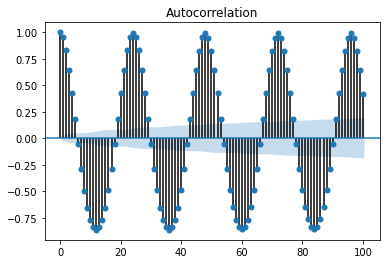

In [78]:
plot_acf(result.seasonal , lags = 100)
plt.show()

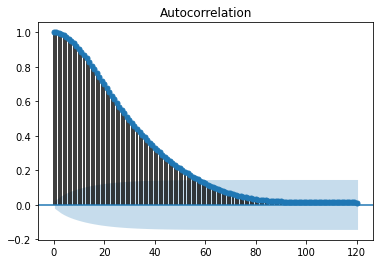

In [5]:
plot_acf(result.trend[20:8200], lags = 120)
plt.show()

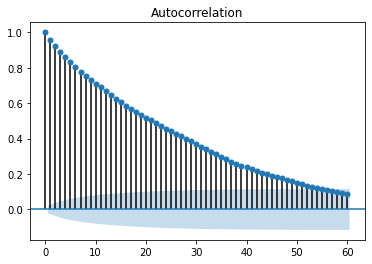

In [99]:
### ACF of observed Data
plot_acf(result.observed[20:8200], lags = 60)
plt.show()

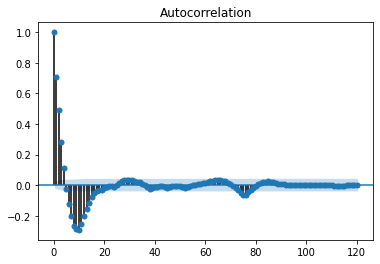

In [98]:
### ACF of residual data (stationary component)
plot_acf(result.resid[20:8200], lags = 120)
plt.show()

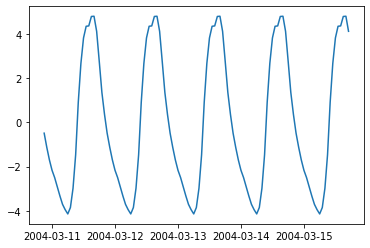

In [107]:
plt.plot(result.seasonal[3:120])

In [101]:
### Pre-processing the Data to be fed into the model
model_data = pd.DataFrame()
data.columns = list(range(14))
for i in range(13):
  x = data[[0,i+1]]
  x = x.set_index(0)
  res = seasonal_decompose(x , model='additive').observed
  model_data = pd.concat([model_data,res] , axis = 1)

model_data.dropna(inplace = True)

lagged_data = pd.DataFrame()
lag = 50
for i in range(lag+1):
  lagged_data = pd.concat([model_data.shift(i),lagged_data] , axis = 1 )

lagged_data.columns = list(range(0,13*lag+13))
lagged_data.dropna(inplace = True)
X = lagged_data[list(range(0,lag*13))]
Y = lagged_data[list(range(lag*13 +10,lag*13 +13))]

lim = int(X.shape[0]*0.8)
trainXdf = X[0:lim]
testXdf = X[lim:]

trainYdf = Y[0:lim]
testYdf = Y[lim:]


trainX = trainXdf.to_numpy()
trainY = trainYdf.to_numpy()
testX = testXdf.to_numpy()
testY = testYdf.to_numpy()

mean = trainX.mean(axis=0).reshape((1, -1))
std = trainX.std(axis=0).reshape((1, -1))

trainX = (trainX - mean) / std
testX = (testX - mean) / std

In [105]:
y_pred_test = pd.DataFrame()
y_pred_train = pd.DataFrame()

svr = SVR(epsilon = 0.2, kernel='rbf' , C = 20  )

svr.fit(trainX, trainY[:,0])
print("train score:",svr.score(trainX , trainY[:,0]) ," test score:" ,svr.score(testX , testY[:,0])) 

train score: 0.889695528524618  test score: 0.9112125389536888


In [106]:
y_pred_train = svr.predict(trainX)
y_pred_test = svr.predict(testX)

(-50.0, 50.0)

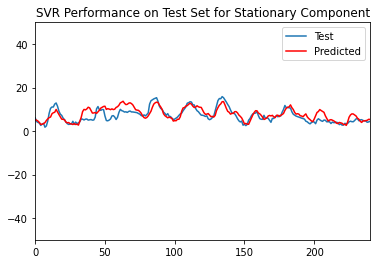

In [107]:
plt.figure()
plt.title("SVR Performance on Test Set for Stationary Component")
plt.plot(testY[:,0] , label='Test') 
plt.plot(y_pred_test , color ='red',label='Predicted')
plt.legend()
plt.xlim([0,240])
plt.ylim([-50,50])

(-50.0, 50.0)

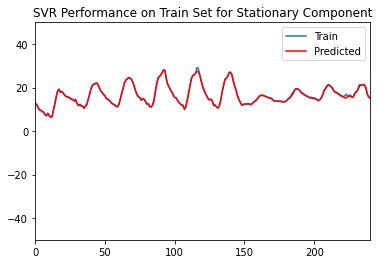

In [108]:
plt.figure()
plt.title("SVR Performance on Train Set for Stationary Component")
plt.plot(trainY[:,0] , label='Train') 
plt.plot(y_pred_train , color ='red',label='Predicted')
plt.legend()
plt.xlim([0,240])
plt.ylim([-50,50])

In [109]:
mae = mean_absolute_error(trainY[:, 0], y_pred_train)
print("Train MAE:",mae)

Train MAE: 2.0957391533586116


In [110]:
mae = mean_absolute_error(testY[:, 0], y_pred_test)
print("Test MAE:",mae)

Test MAE: 3.7397167472850668


In [46]:
### Applying SVR using GridSearchCV for selecting hyperparameters and predicting the next values of all the 3 series for train and test set

y_pred_test = pd.DataFrame()
y_pred_train = pd.DataFrame()
params = [{'kernel': ['rbf',], 'gamma': [1,0.1,0.001], 'C': [1,20,100]}]

for i in range(3):
   
    
    lim = int(X.shape[0]*0.8)
    trainXdf = X[0:lim]
    testXdf = X[lim:]

    trainYdf = Y[0:lim]
    testYdf = Y[lim:]


    trainX = trainXdf.to_numpy()
    trainY = trainYdf.to_numpy()
    testX = testXdf.to_numpy()
    testY = testYdf.to_numpy()

    mean = trainX.mean(axis=0).reshape((1, -1))
    std = trainX.std(axis=0).reshape((1, -1))

    trainX = (trainX - mean) / std
    testX = (testX - mean) / std

    gs = GridSearchCV(SVR(), params ,n_jobs=-1 )
    gs.fit(trainX, trainY[:,i])

    svr = gs.best_estimator_

    svr.fit(trainX, trainY[:,i])
    pred = pd.DataFrame(svr.predict(testX))
    y_pred_test = pd.concat([y_pred_test,pred], axis=1)
    pred = pd.DataFrame(svr.predict(trainX))
    y_pred_train = pd.concat([y_pred_train,pred], axis=1)
    if i == 0:
      txt = "T"
    if i==1:
      txt="RH"
    if i==2:
      txt="AH"
    print(txt," best params:", gs.best_params_ )
    print(txt," best score:", gs.best_score_ )
    print(txt," train score:",svr.score(trainX , trainY[:,i]) ," test score:" ,svr.score(testX , testY[:,i])) 


T  best params: {'C': 20, 'gamma': 0.001, 'kernel': 'rbf'}
T  best score: 0.7251854459334865
T  train score: 0.8948543934663634  test score: 0.925578163085682
RH  best params: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
RH  best score: 0.8261010351674754
RH  train score: 0.9136349246681461  test score: 0.93165119391227
AH  best params: {'C': 20, 'gamma': 0.001, 'kernel': 'rbf'}
AH  best score: 0.6382846581758651
AH  train score: 0.891654078071825  test score: 0.9238232444018477


In [48]:
mae_test = 0 
mae_train = 0
for i in range(3):
  mae_test = mae_test+ mean_absolute_error(testY[:, i], y_pred_test.iloc[:,i])
  mae_train = mae_train+ mean_absolute_error(trainY[:, i], y_pred_train.iloc[:,i])
print("Test MAE:",mae_test/3," , Train MAE",mae_train/3 )

Test MAE: 2.5250953031693126  , Train MAE 2.2384718441699913


In [111]:
trainX = trainX.reshape((trainX.shape[0], lag, 13))
testX = testX.reshape((testX.shape[0], lag, 13))
model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY[:, 0], epochs=50, batch_size=72, validation_data=(testX, testY[:, 0]), verbose=0, shuffle=False)

(-50.0, 50.0)

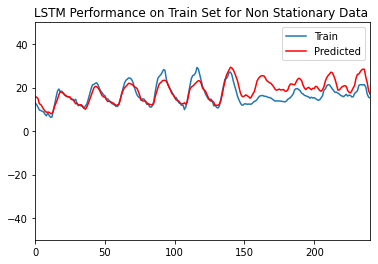

In [112]:
y_pred_train = model.predict(trainX)

plt.figure()
plt.plot(trainY[:,0] , label='Train') 
plt.title("LSTM Performance on Train Set for Non Stationary Data ")
plt.plot(y_pred_train , color ='red',label='Predicted')
plt.legend()
plt.xlim([0,240])
plt.ylim([-50,50])


(-50.0, 50.0)

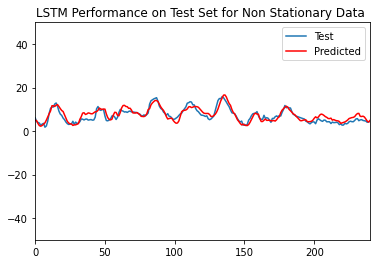

In [113]:
y_pred_test = model.predict(testX)

plt.figure()
plt.title("LSTM Performance on Test Set for Non Stationary Data ")
plt.plot(testY[:,0] , label='Test' ) 
plt.plot(y_pred_test , color ='red',label='Predicted')
plt.legend()
plt.xlim([0,240])
plt.ylim([-50,50])


In [ ]:
mae = mean_absolute_error(testY[:, 0], y_pred_test)
print("Test MAE:",mae)

In [ ]:
mae = mean_absolute_error(trainY[:, 0], y_pred_train)
print("Train MAE:",mae)

In [51]:
### Reshaping the input to be fed into LSTM in the form of (number of samples , number of timesteps , number of features per timesetep)

trainX = trainX.reshape((trainX.shape[0], lag, 13))
testX = testX.reshape((testX.shape[0], lag, 13))
y_pred_test = pd.DataFrame()
y_pred_train = pd.DataFrame()

#### Applying LSTM to the 50 time series and predicting the next timestep values for train and test set

for i in range(3):
    model = Sequential()
    model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    history = model.fit(trainX, trainY[:, i], epochs=50, batch_size=64, validation_data=(testX, testY[:, i]), verbose=0, shuffle=False)
    pred = pd.DataFrame(model.predict(testX))
    y_pred_test = pd.concat([y_pred_test,pred], axis=1)
    pred = pd.DataFrame(model.predict(trainX))
    y_pred_train = pd.concat([y_pred_train,pred], axis=1)
    if i == 0:
      txt = "T"
    if i==1:
      txt="RH"
    if i==2:
      txt="AH"
    print(txt,"Train score", model.evaluate(trainX,trainY[:,i]) , "Test Score :",model.evaluate(testX,testY[:,i]))
    

59/59 [==============================] - 0s 4ms/step - loss: 7.8122
T Train score 8.446118354797363 Test Score : 7.8122406005859375
59/59 [==============================] - 0s 4ms/step - loss: 8.7487
RH Train score 8.964377403259277 Test Score : 8.748702049255371
59/59 [==============================] - 0s 4ms/step - loss: 2.6987
AH Train score 2.425415515899658 Test Score : 2.698676586151123


In [53]:
mae_test = 0 
mae_train = 0
for i in range(3):
  mae_test = mae_test+ mean_absolute_error(testY[:, i], y_pred_test.iloc[:,i])
  mae_train = mae_train+ mean_absolute_error(trainY[:, i], y_pred_train.iloc[:,i])
print("Test MAE:",mae_test/3," , Train MAE",mae_train/3 )

Test MAE: 6.419872773506458  , Train MAE 6.61197094815859
